In [1]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn import SAGEConv
from dgl.nn.pytorch import GraphConv,GATConv,ChebConv
import numpy as np
import dask.diagnostics
import fsspec
import xarray as xr
from dgl.nn.pytorch.factory import KNNGraph
import matplotlib.pyplot as plt
import networkx as nx
import os
from torch.utils.data import DataLoader
import torch.optim as optim
import warnings
import time
import select as sl
import pickle
import fv3viz

/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

Pressure=0 # Pressure=1 if you want to use surface pressure (with Z500) as the second variable or 0 if you want to use thickness
lead=6

nameModel='Atten' # There are 3 optiones: 'Atten' 'GCN' 'GeneralAtten'
residual=True    # Trained based on residual or full state 

In [3]:
if Pressure==1:
    

    variableList=['h500','PRESsfc']

    Zmean=5765.8457   #Z500mean=5765.8457, 
    Zstd=90.79599   #Z500std=90.79599

    Tmean=98683.26     #SurfPressmean=98683.26
    Tstd=6049.9487     #SurfPressstd=6049.9487
    
    data_url1 = "gs://vcm-ml-scratch/ebrahimn/2022-07-02/experiment-5-y/fv3gfs_run/"
    state_testing_data = xr.open_zarr(fsspec.get_mapper(os.path.join(data_url1, 'atmos_dt_atmos.zarr')))

    Z500test=state_testing_data[variableList[0]].isel(time=slice(9000,13000))
    Ttest=state_testing_data[variableList[1]].isel(time=slice(9000,13000))

    Z500test=np.swapaxes(Z500test.values, 1, 0)
    Ttest=np.swapaxes(Ttest.values, 1, 0)

    Z500test=Z500test.reshape(np.size(Z500test, 0), np.size(Z500test, 1)*np.size(Z500test, 2)*np.size(Z500test, 3))
    Ttest=Ttest.reshape(np.size(Ttest, 0), np.size(Ttest, 1)*np.size(Ttest, 2)*np.size(Ttest, 3))

    Ttest=(Ttest-Tmean)/Tstd
    Z500test=(Z500test-Zmean)/Zstd


    Z500test=np.swapaxes(Z500test, 1, 0)
    Ttest=np.swapaxes(Ttest, 1, 0)

elif Pressure==0:


    variableList=['h500','h200','h850']

    Zmean=5765.8457   #Z500mean=5765.8457, 
    Zstd=90.79599   #Z500std=90.79599

    Tmean=10643.382          #Thickmean=10643.382
    Tstd=162.12427              #Thickstd=162.12427

    data_url1 = "gs://vcm-ml-scratch/ebrahimn/2022-07-02/experiment-5-y/fv3gfs_run/"
    state_testing_data = xr.open_zarr(fsspec.get_mapper(os.path.join(data_url1, 'atmos_dt_atmos.zarr')))

    Z500test=state_testing_data[variableList[0]].isel(time=slice(9000,13000))
    Ttest1=state_testing_data[variableList[1]].isel(time=slice(9000,13000))
    Ttest2=state_testing_data[variableList[2]].isel(time=slice(9000,13000))

    Z500test=np.swapaxes(Z500test.values, 1, 0)
    Ttest1=np.swapaxes(Ttest1.values, 1, 0)
    Ttest2=np.swapaxes(Ttest2.values, 1, 0)

    Ttest=Ttest1-Ttest2

    Z500test=Z500test.reshape(np.size(Z500test, 0), np.size(Z500test, 1)*np.size(Z500test, 2)*np.size(Z500test, 3))
    Ttest=Ttest.reshape(np.size(Ttest, 0), np.size(Ttest, 1)*np.size(Ttest, 2)*np.size(Ttest, 3))
    
    Z500test=(Z500test-Zmean)/Zstd
    Ttest=(Ttest-Tmean)/Tstd


    Z500test=np.swapaxes(Z500test, 1, 0)
    Ttest=np.swapaxes(Ttest, 1, 0)

In [4]:
lat_lon_data = xr.open_zarr(fsspec.get_mapper(os.path.join(data_url1, 'state_after_timestep.zarr')))
lat1=(lat_lon_data.latitude[1].load())
lon1=(lat_lon_data.longitude[1].load())
lat=lat1.values.flatten()
lon=lon1.values.flatten()
len(lon)

13824

In [5]:
g = pickle.load(open("UpdatedGraph", 'rb'))

In [6]:
if nameModel=='Atten':
    class GATDefault(nn.Module):
          def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
              super(GATDefault, self).__init__()
              self.layer1 = GATConv(in_dim, hidden_dim, num_heads)
              # Be aware that the input dimension is hidden_dim*num_heads since
              # multiple head outputs are concatenated together. Also, only
              # one attention head in the output layer.
              self.layer2 = GATConv(hidden_dim * num_heads, out_dim, 1)

          def forward(self, g, h):
              h = self.layer1(g, h)
              # Concat last 2 dim (num_heads * out_dim)
              h = h.view(-1, h.size(1) * h.size(2)) # (in_feat, num_heads, out_dim) -> (in_feat, num_heads * out_dim)
              h = F.elu(h)
              h = self.layer2(g, h)
              # Sueeze the head dim as it's = 1 
              h = h.squeeze() # (in_feat, 1, out_dim) -> (in_feat, out_dim)
              return h

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if residual:
      weightFile='Residual_Graph'  
      savename='Residual_Attention' 
    else:
      weightFile='Full_Graph'  
      savename='Full_Attention'  

    net = GATDefault(in_dim=2,hidden_dim=256,out_dim=2,num_heads=2).to(device)
    net.load_state_dict(torch.load(weightFile+'.pt'))
    net.to(device)
    net.eval()

    print('Model loaded')
    M=500
    autoreg_pred = np.zeros([M,len(lon),2])
    rmse_Z=np.zeros([int(M/4)])
    rmse_T=np.zeros([int(M/4)])
    cc=0

    for k in range(0,M):

      if residual:

        if (k==0):
            autoreg_pred[k,:,:] =net(g,torch.from_numpy(np.concatenate((Z500test[:,[0]], Ttest[:,[0]]), axis=1)).float()).detach().cpu().numpy()
            autoreg_pred[k,:,:] += np.concatenate((Z500test[:,[0]], Ttest[:,[0]]), axis=1)
            if k % 4 == 0:
                rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k+lead])**2))
                rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k+lead])**2))
                cc+=1
        else:
            autoreg_pred[k,:,:] =net(g,torch.from_numpy(autoreg_pred[k-1,:,:]).float()).detach().cpu().numpy()
            autoreg_pred[k,:,:] += autoreg_pred[k-1,:,:]
            if k % 4 == 0:
                rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k*lead+1])**2))
                rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k*lead+1])**2))
                cc+=1

      else:

          if (k==0):
            autoreg_pred[k,:,:] =net(g,torch.from_numpy(np.concatenate((Z500test[:,[0]], Ttest[:,[0]]), axis=1)).float()).detach().cpu().numpy()
            if k % 4 == 0:
                rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k+lead])**2))
                rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k+lead])**2))
                cc+=1
          else:
            autoreg_pred[k,:,:] =net(g,torch.from_numpy(autoreg_pred[k-1,:,:]).float()).detach().cpu().numpy()
            if k % 4 == 0:
              rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k*lead+1])**2))
              rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k*lead+1])**2))
              cc+=1
      if k % 24 == 0:
                print(f"day: {k*lead/24}")

Model loaded
day: 0.0
day: 6.0
day: 12.0
day: 18.0
day: 24.0
day: 30.0
day: 36.0
day: 42.0
day: 48.0
day: 54.0
day: 60.0
day: 66.0
day: 72.0
day: 78.0
day: 84.0
day: 90.0
day: 96.0
day: 102.0
day: 108.0
day: 114.0
day: 120.0


In [7]:
if nameModel=='GeneralAtten':
    class GAT(nn.Module):
        def __init__(self,
                    g,
                    num_layers,
                    in_dim,
                    num_hidden,
                    out_dim,
                    heads):
            super(GAT, self).__init__()
            self.g = g
            self.num_layers = num_layers
            self.gat_layers = nn.ModuleList()
            if num_layers > 1:
            # input projection (no residual)
                self.gat_layers.append(GATConv(
                    in_dim, num_hidden, heads[0], False))
                # hidden layers
                for l in range(1, num_layers-1):
                    # due to multi-head, the in_dim = num_hidden * num_heads
                    self.gat_layers.append(GATConv(
                        num_hidden * heads[l-1], num_hidden, heads[l]))
                # output projection
                self.gat_layers.append(GATConv(
                    num_hidden * heads[-2], out_dim, heads[-1]))
            else:
                self.gat_layers.append(GATConv(
                    in_dim, out_dim, heads[0]))

        def forward(self, inputs):
            h = inputs
            for l in range(self.num_layers):
                h = self.gat_layers[l](self.g, h)
                h = h.flatten(1) if l != self.num_layers - 1 else h.mean(1)
            return h


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss()
    net = GAT(g,num_layers=4,in_dim=2,num_hidden=256,out_dim=2,heads=[2,2,2]).to(device)

    if residual:
      weightFile='Residual_General_Graph'  
      savename='Residual_General_Attention' 
    else:
      weightFile='Full_General_Graph'  
      savename='Full_General_Attention'  
      
    net.load_state_dict(torch.load(weightFile+'.pt'))
    net.to(device)
    net.eval()

    print('Model loaded')
    M=500
    autoreg_pred = np.zeros([M,len(lon),2])
    rmse_Z=np.zeros([int(M/4)])
    rmse_T=np.zeros([int(M/4)])
    cc=0

    for k in range(0,M):

      if residual:

        if (k==0):
            autoreg_pred[k,:,:] =net(torch.from_numpy(np.concatenate((Z500test[:,[0]], Ttest[:,[0]]), axis=1)).float()).detach().cpu().numpy()
            autoreg_pred[k,:,:] += np.concatenate((Z500test[:,[0]], Ttest[:,[0]]), axis=1)
            if k % 4 == 0:
                rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k+lead])**2))
                rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k+lead])**2))
                cc+=1
        else:
            autoreg_pred[k,:,:] =net(torch.from_numpy(autoreg_pred[k-1,:,:]).float()).detach().cpu().numpy()
            autoreg_pred[k,:,:] += autoreg_pred[k-1,:,:]
            if k % 4 == 0:
                rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k*lead+1])**2))
                rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k*lead+1])**2))
                cc+=1

      else:

          if (k==0):
            autoreg_pred[k,:,:] =net(torch.from_numpy(np.concatenate((Z500test[:,[0]], Ttest[:,[0]]), axis=1)).float()).detach().cpu().numpy()
            if k % 4 == 0:
                rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k+lead])**2))
                rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k+lead])**2))
                cc+=1
          else:
            autoreg_pred[k,:,:] =net(torch.from_numpy(autoreg_pred[k-1,:,:]).float()).detach().cpu().numpy()
            if k % 4 == 0:
              rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k*lead+1])**2))
              rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k*lead+1])**2))
              cc+=1
      if k % 24 == 0:
                print(f"day: {k*lead/24}")



In [8]:
if nameModel=='GCN':
    class GCN(nn.Module):
      def __init__(self,
                  g,
                  in_feats,
                  n_hidden,
                  out_dim,
                  n_layers,
                  activation):
          super(GCN, self).__init__()
          self.g = g
          self.layers = nn.ModuleList()
          # input layer
          self.layers.append(GraphConv(in_feats, n_hidden, weight=True, activation=activation))
          # hidden layers
          for i in range(n_layers - 1):
              self.layers.append(GraphConv(n_hidden, n_hidden, weight=True, activation=activation))
          # output layer
          self.layers.append(GraphConv(n_hidden, out_dim))
          #self.dropout = nn.Dropout(p=dropout)

      def forward(self, features):
          h = features
          for i, layer in enumerate(self.layers):
              #if i != 0:
                  #h = self.dropout(h)
              h = layer(self.g, h)
          return h

    if residual:
      weightFile='Residual_GCN'  
      savename='Residual_GCN' 
    else:
      weightFile='Full_GCN'  
      savename='Full_GCN'  

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = GCN(g, in_feats=2,out_dim=2,n_layers=4,n_hidden=256,activation=F.relu).to(device)
    net.load_state_dict(torch.load(weightFile+'.pt'))
    net.to(device)
    net.eval()
    print('Model loaded')
    M=500
    autoreg_pred = np.zeros([M,len(lon),2])
    rmse_Z=np.zeros([int(M/4)])
    rmse_T=np.zeros([int(M/4)])
    cc=0

    for k in range(0,M):

      if (k==0):
        autoreg_pred[k,:,:] =net(torch.from_numpy(np.concatenate((Z500test[:,[0]], Ttest[:,[0]]), axis=1)).float()).detach().cpu().numpy()
        if k % 4 == 0:
          rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k+lead])**2))
          rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k+lead])**2))
          cc+=1
      else:
        autoreg_pred[k,:,:] =net(torch.from_numpy(autoreg_pred[k-1,:,:]).float()).detach().cpu().numpy()
        if k % 4 == 0:
          rmse_Z[cc]=np.sqrt(np.mean((autoreg_pred[k,:,0]-Z500test[:,k*lead+1])**2))
          rmse_T[cc]=np.sqrt(np.mean((autoreg_pred[k,:,1]-Ttest[:,k*lead+1])**2))
          cc+=1
      if k % 24 == 0:
                print(f"day: {k*lead/24}")


In [9]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [10]:
persistence=np.zeros(len(rmse_Z))
for k in np.arange(0,len(rmse_Z)):
    persistence[k]=np.mean((Z500test[:, k*lead+1] - Z500test[:, 0])**2)**0.5

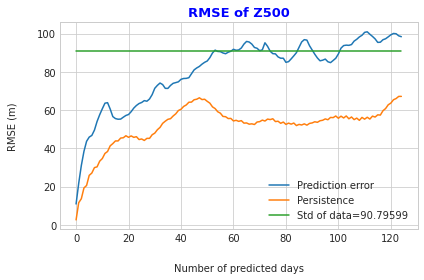

In [11]:
fig = plt.figure()
ax = plt.axes()

x = np.arange(0,int(M/4), 1)
ax.plot(x, rmse_Z*Zstd, label='Prediction error')
ax.plot(x, persistence*Zstd, label='Persistence')
ax.plot(x,np.ones(len(x))*Zstd, label=f"Std of data={Zstd}")
ax.set_xlabel('Number of predicted days', labelpad=20)
ax.set_ylabel('RMSE (m)', labelpad=20)
plt.title(f'RMSE of Z500', fontsize = 13, 
                fontweight = 'bold', color = 'b')
ax.legend()
plt.tight_layout()
# plt.savefig('Z500_RMSE'+savename+'.png', format = 'png', dpi = 600)

In [12]:
persistence=np.zeros(len(rmse_T))
for k in np.arange(0,len(rmse_T)):
    persistence[k]=np.mean((Ttest[:, k*lead+1] - Ttest[:, 0])**2)**0.5

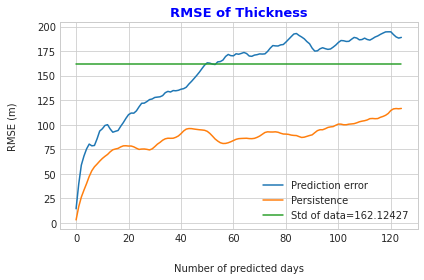

In [13]:
fig = plt.figure()
ax = plt.axes()

x = np.arange(0,int(M/4), 1)

ax.plot(x, rmse_T*Tstd, label='Prediction error')
ax.plot(x, persistence*Tstd, label='Persistence')
ax.plot(x,np.ones(len(x))*Tstd, label=f"Std of data={Tstd}")

ax.set_xlabel('Number of predicted days', labelpad=20)
ax.set_ylabel('RMSE (m)', labelpad=20)
plt.title(f'RMSE of Thickness', fontsize = 13, 
                fontweight = 'bold', color = 'b')

ax.legend()
plt.tight_layout()
# plt.savefig('Thick_RMSE'+savename+'.png', format = 'png', dpi = 600)

In [14]:
autoreg_pred[:,:,0]=(autoreg_pred[:,:,0]*Zstd)+Zmean
autoreg_pred[:,:,1]=(autoreg_pred[:,:,1]*Tstd)+Tmean

Z_truth=(Z500test[:,lead:M*lead+1:lead]*Zstd)+Zmean
T_truth=(Ttest[:,lead:M*lead+1:lead]*Tstd)+Tmean

Z_truth=np.swapaxes(Z_truth,1,0)
T_truth=np.swapaxes(T_truth,1,0)

In [15]:
autoreg_pred1=autoreg_pred[:,:,0]
autoreg_pred2=autoreg_pred[:,:,1]

autoreg_pred1=autoreg_pred1.reshape(np.size(autoreg_pred1, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))
autoreg_pred2=autoreg_pred2.reshape(np.size(autoreg_pred2, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))


Z_truth=Z_truth.reshape(np.size(Z_truth, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))
T_truth=T_truth.reshape(np.size(T_truth, 0), np.size(lat1, 0),np.size(lat1, 1),np.size(lat1, 2))

In [16]:
data_xr1 = xr.DataArray(autoreg_pred1, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

data_xr2 = xr.DataArray(autoreg_pred2, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])


data_xr1_truth = xr.DataArray(Z_truth, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

data_xr2_truth = xr.DataArray(T_truth, 
coords={'time':np.arange(0,M),'tile': np.arange(0,6),'y': lat1.y,'x': lat1.x}, 
dims=["time","tile","y", "x"])

In [17]:
# need to have this grid data merged into the dataset to plot it

from vcm.catalog import catalog

ds=data_xr1.to_dataset(name='Predicted_Z500')
ds=ds.merge(data_xr2.to_dataset(name='Predicted_Thickness'))
ds=ds.merge(data_xr1_truth.to_dataset(name='Truth_Z500'))
ds=ds.merge(data_xr2_truth.to_dataset(name='Truth_Thickness'))

grid = catalog["grid/c48"].read()
common_coords = {"tile": range(6), "x": range(48), "y": range(48)}
grid = grid.assign_coords(common_coords)
ds = ds.merge(grid)

/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  # This is added back by InteractiveShellApp.init_path()
/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  # This is added back by InteractiveShellApp.init_path()
/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  # This is added back by InteractiveShellApp.init_path()
/home/ebrahimn/miniconda3/envs/dlwp/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The left and right margins cannot 

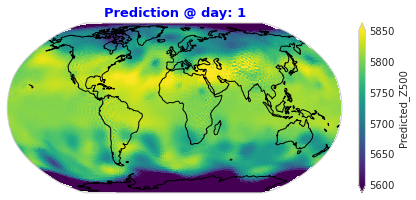

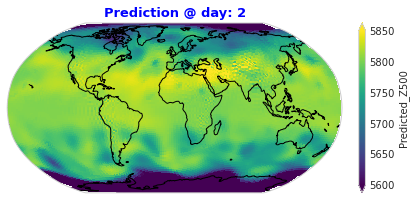

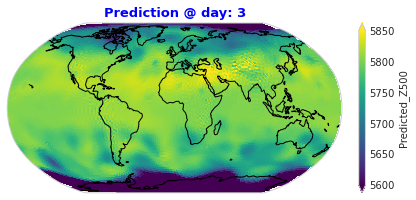

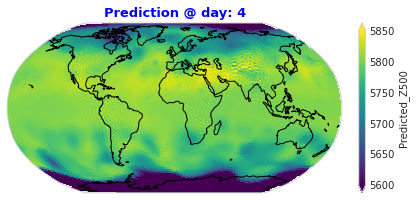

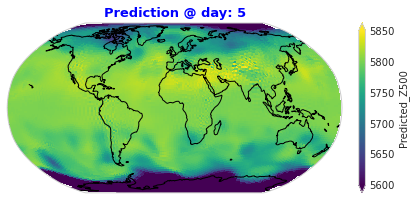

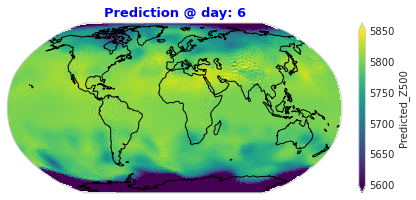

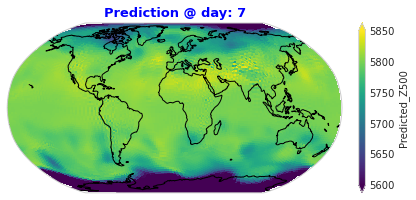

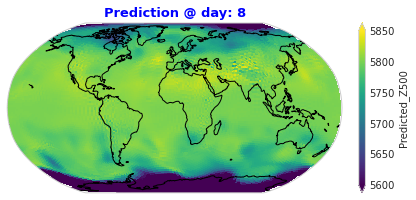

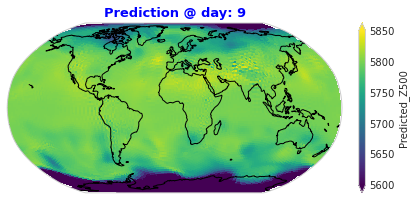

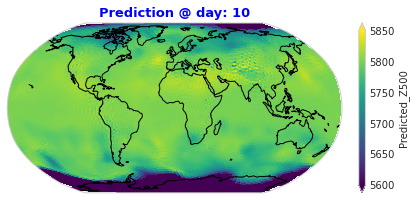

In [18]:
for dd in np.arange(4,44,4):
    fv3viz.plot_cube(ds.isel(time=dd), "Truth_Z500",vmax = 5850, vmin = 5600)
    plt.title(f'Truth @ day: {int(dd/4)}', fontsize = 13, 
                fontweight = 'bold', color = 'b')
    plt.tight_layout()
    plt.savefig('Glob_Truth_'+savename +'_'+str(dd/4)+'_.png', format = 'png', dpi = 600, bbox_inches='tight')

    fv3viz.plot_cube(ds.isel(time=dd), "Predicted_Z500",vmax = 5850, vmin = 5600)
    plt.title(f'Prediction @ day: {int(dd/4)}', fontsize = 13, 
                fontweight = 'bold', color = 'b')
    plt.tight_layout()
    plt.savefig('Glob_Prediction_'+savename +'_'+str(dd/4)+'_.png', format = 'png', dpi = 600, bbox_inches='tight')